# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [10]:
df['sex'] = ['M' if x == 1.0 else 'F' for x in df['sex']]

A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

### 1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [13]:
def gera_crosstab(df: pd.DataFrame, resposta: str, explicativa: str) -> pd.DataFrame:
    
    tab = pd.crosstab(df[explicativa], df[resposta], margins= True)
    tab['media'] = tab[1]/tab['All']
    tab['odds'] = tab[1]/tab[0]
    tab['odds_ratio_total'] = tab['odds']/tab.loc['All','odds']
    tab['logito'] = np.log(tab['odds'])
    tab['woe'] = np.log(tab['odds_ratio_total'])
    
    return tab

In [14]:
gera_crosstab(df,'flag_doente','sex')

flag_doente,0,1,All,media,odds,odds_ratio_total,logito,woe
sex,,,,,,,,
F,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
M,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [16]:
gera_crosstab(df,'flag_doente','ca')

flag_doente,0,1,All,media,odds,odds_ratio_total,logito,woe
ca,,,,,,,,
0.0,130,46,176,0.261364,0.353846,0.417488,-1.038893,-0.873501
1.0,21,44,65,0.676923,2.095238,2.472079,0.739667,0.905060
2.0,7,31,38,0.815789,4.428571,5.225077,1.488077,1.653470
3.0,3,17,20,0.850000,5.666667,6.685851,1.734601,1.899994
?,3,1,4,0.250000,0.333333,0.393285,-1.098612,-0.933220
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [17]:
gera_crosstab(df,'flag_doente','thal')

flag_doente,0,1,All,media,odds,odds_ratio_total,logito,woe
thal,,,,,,,,
3.0,129,37,166,0.222892,0.286822,0.338408,-1.248894,-1.083502
6.0,6,12,18,0.666667,2.000000,2.359712,0.693147,0.858540
7.0,28,89,117,0.760684,3.178571,3.750257,1.156432,1.321824
?,1,1,2,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


A variável 'ca' apresenta a discriminação de risco mais marcante devido à distribuição de ocorrência da doença em suas categorias.

### 2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  

Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [24]:
def gera_crosstab(df: pd.DataFrame, resposta: str, explicativa: str, categorias = 5) -> pd.DataFrame:
    
    var_exp = explicativa+'_group'
    df[var_exp] = pd.qcut(df[explicativa],categorias)
    tab = pd.crosstab(df[var_exp], df[resposta], margins= True)
    tab['media'] = tab[1]/tab['All']
    tab['odds'] = tab[1]/tab[0]
    tab['odds_ratio_total'] = tab['odds']/tab.loc['All','odds']
    tab['logito'] = np.log(tab['odds'])
    tab['woe'] = np.log(tab['odds_ratio_total'])
    
    return tab

In [26]:
gera_crosstab(df,'flag_doente','age')

flag_doente,0,1,All,media,odds,odds_ratio_total,logito,woe
age_group,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [28]:
gera_crosstab(df,'flag_doente','age',10)

flag_doente,0,1,All,media,odds,odds_ratio_total,logito,woe
age_group,,,,,,,,
"(28.999, 42.0]",28,8,36,0.222222,0.285714,0.337102,-1.252763,-1.087370
"(42.0, 45.0]",19,8,27,0.296296,0.421053,0.496782,-0.864997,-0.699605
"(45.0, 50.0]",18,13,31,0.419355,0.722222,0.852118,-0.325422,-0.160030
"(50.0, 53.0]",24,9,33,0.272727,0.375000,0.442446,-0.980829,-0.815437
"(53.0, 56.0]",18,17,35,0.485714,0.944444,1.114309,-0.057158,0.108234
"(56.0, 58.0]",14,22,36,0.611111,1.571429,1.854060,0.451985,0.617378
"(58.0, 59.4]",5,9,14,0.642857,1.800000,2.123741,0.587787,0.753179
"(59.4, 62.0]",8,23,31,0.741935,2.875000,3.392086,1.056053,1.221445
"(62.0, 66.0]",17,17,34,0.500000,1.000000,1.179856,0.000000,0.165392


### 3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [32]:
reglog = smf.logit('flag_doente ~ sex + C(cp) + trestbps + age',data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3097
Time:                        18:57:33   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.3407      1.621     -5.145      0.000     -11.518      -5.163
sex[T.M]         1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2.0]    -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3.0]     0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4.0]     2.4789      0.553      4.485      0.000       1.396       3.562
trestbps         0.0193      0.009      2.261      0.024       0.003       0.036
age              0.0567      0.018      3.120      0.002       0.021       0.092
================================================================================
"""

Temos 4 variáveis importantes correlacionadas ao modelo, o que é atestado pelo p-valor abaixo de 5% em cada uma.

Com relação aos coeficientes, temos que se o indivíduo é homem há 1.8 vezes a possibilidade de estar doente.

É interessante notar que se comparado a cp = 1, apenas cp=4 aparenta impactar positivamente o modelo, visto o alto p-valor das demais categorias de cp.

### 4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [34]:
df['predito'] = reglog.predict(df)

In [36]:
cat_pred = pd.qcut(df['predito'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
qualid['predito'] = group_reg['predito'].mean()
qualid['pct_doente'] = group_reg['flag_doente'].mean()

Text(0.5, 0, 'Grupo')

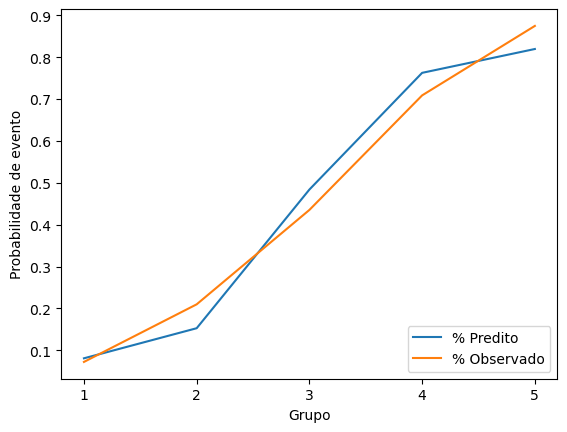

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_doente'].plot(label='% Predito')
ax = qualid['predito'].plot(label='% Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

### 5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [41]:
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

KS: 59.30% 
AUC: 85.19% 
GINI: 70.39%


### 6. Tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
Avalie as características do seu modelo (calibragem e acurácia).

In [74]:
reglog_melhorado = smf.logit('flag_doente ~ sex + C(cp) + chol + fbs + trestbps + age',data=df).fit()
reglog_melhorado.summary()

Optimization terminated successfully.
         Current function value: 0.472175
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3154
Time:                        19:11:42   Log-Likelihood:                -143.07
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.173e-24
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -9.2716      1.769     -5.242      0.000     -12.738      -5.805
sex[T.M]         1.9370      0.369      5.256      0.000       1.215       2.659
C(cp)[T.2.0]    -0.1053      0.643     -0.164      0.870      -1.367       1.156
C(cp)[T.3.0]     0.0522      0.579      0.090      0.928      -1.082       1.186
C(cp)[T.4.0]     2.4563      0.560      4.389      0.000       1.359       3.553
chol             0.0046      0.003      1.565      0.118      -0.001       0.010
fbs              0.0484      0.412      0.117      0.907      -0.760       0.857
trestbps         0.0182      0.009      2.095      0.036       0.001       0.035
age              0.0541      0.018      2.936      0.003       0.018       0.090
================================================================================
"""

In [75]:
df['predito_melhorado'] = reglog_melhorado.predict(df)

In [76]:
cat_pred = pd.qcut(df['predito_melhorado'], 5, duplicates='drop')
cat_pred.value_counts().sort_index()
group_reg = df.groupby(cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
qualid['predito_melhorado'] = group_reg['predito_melhorado'].mean()
qualid['pct_doente_melhorado'] = group_reg['flag_doente'].mean()

In [77]:
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito_melhorado'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito_melhorado'], df.loc[df['flag_doente'] != 1, 'predito_melhorado']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

KS: 60.95% 
AUC: 85.61% 
GINI: 71.21%
